# working with C2L outputs, Loading and working with processed Visium data fetiatric

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2024-09-20 11:24.


In [2]:
## For correct plotting of the images
import matplotlib
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("")
# print(font_manager.findfont("Arial"))
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')
os.chdir('')
# os.getcwd()

# load paed dataset

In [3]:
# load raw unified object 
adata_all_paed = sc.read_h5ad('')
del adata_all_paed.obs['cma_v1'] # remove old axis 
# filter spots by coverage
adata_filt_paed = adata_all_paed.copy()
sc.pp.filter_genes(adata_filt_paed,min_counts=2) # retain at least 3 levels of expression 0,1,2
adata_filt_paed = adata_filt_paed[adata_filt_paed.obs['tot_cell_abundance']>25,:].copy()
adata_filt_paed = adata_filt_paed[adata_filt_paed.obs['n_genes_by_counts']>1000,:]
adata_filt_paed = adata_filt_paed[adata_filt_paed.obs['annotations_level_0']!='Artifacts']
adata_filt_paed = adata_filt_paed[adata_filt_paed.obs['annotations_level_0']!='Background']
adata_filt_paed = adata_filt_paed[adata_filt_paed.obs['annotations_level_0']!='Unassigned']
adata_filt_paed = adata_filt_paed[~adata_filt_paed.obs['annotations_level_0'].isna()]
sc.pp.normalize_total(adata_filt_paed,target_sum=2500)
sc.pp.log1p(adata_filt_paed)
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')
adata_cma_paed = adata_filt_paed[adata_filt_paed.obs['annotations_level_0']!="lymph"].copy()

/home/jovyan/my-conda-envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
## remove meduala less lobules 
adata_cma_paed.obs['full_lobule'] = 0
for s in adata_cma_paed.obs['SampleID'].cat.categories.tolist():
    sample = adata_cma_paed[adata_cma_paed.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=1) & (med.size>=1):
            adata_cma_paed.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_cma_paed.obs['full_lobule'] = adata_cma_paed.obs['full_lobule'].astype('category')
# adata_cma_paed.obs['full_lobule'].value_counts()
adata_cma_paed = adata_cma_paed[adata_cma_paed.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data
del adata_all_paed
del adata_filt_paed
# adata_cma_paed

In [5]:
# generate bins if there is a previuos axis you might need to rerun 
import imagespot_rev_v1 as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_cma_paed.obs = ims.bin_axis_new(ct_order ,ct2_values,adata_cma_paed.obs,'cma_v2')   
adata_cma_paed.obs.loc[adata_cma_paed.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_cma_paed.obs['manual_bin_cma_v2'] = adata_cma_paed.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_cma_paed.obs['manual_bin_cma_v2'].value_counts()
ct_integer_map = {category: index for index, category in enumerate(ct_order)}
adata_cma_paed.obs['manual_bin_cma_v2_int'] = adata_cma_paed.obs['manual_bin_cma_v2'].map(ct_integer_map)


Capsular = (-0.75 > cma_v2)
Sub-Capsular = (-0.75 <= cma_v2) & (-0.62 > cma_v2)
Cortical level 1 = (-0.62 <= cma_v2) & (-0.55 > cma_v2)
Cortical level 2 = (-0.55 <= cma_v2) & (-0.45 > cma_v2)
Cortical level 3 = (-0.45 <= cma_v2) & (-0.3 > cma_v2)
Cortical CMJ = (-0.3 <= cma_v2) & (0.1 > cma_v2)
Medullar CMJ = (0.1 <= cma_v2) & (0.55 > cma_v2)
Medullar level 1 = (0.55 <= cma_v2) & (0.65 > cma_v2)
Medullar level 2 = (0.65 <= cma_v2) & (0.7 > cma_v2)
Medullar level 3 = (0.7 <= cma_v2)


Cortical level 2    4151
Cortical level 1    3840
Cortical level 3    2598
Capsular            2293
Medullar level 3    2089
Cortical CMJ        1949
Medullar CMJ        1944
Sub-Capsular        1584
Medullar level 1    1540
Medullar level 2    1270
Name: manual_bin_cma_v2, dtype: int64

# load fetal 

In [6]:
# load raw unified object 
adata_fet_all = sc.read_h5ad('')
del adata_fet_all.obs['cma_v1'] # remove old axis 
# filter spots by coverage
adata_fet_filt = adata_fet_all.copy()
sc.pp.filter_genes(adata_fet_filt,min_counts=2) # retain at least 3 levels of expression 0,1,2
adata_fet_filt = adata_fet_filt[adata_fet_filt.obs['tot_cell_abundance']>25,:].copy()
adata_fet_filt = adata_fet_filt[adata_fet_filt.obs['n_genes_by_counts']>1000,:]
adata_fet_filt = adata_fet_filt[adata_fet_filt.obs['annotations_level_0']!='Artifacts']
adata_fet_filt = adata_fet_filt[adata_fet_filt.obs['annotations_level_0']!='Background']
adata_fet_filt = adata_fet_filt[adata_fet_filt.obs['annotations_level_0']!='Unassigned']
adata_fet_filt = adata_fet_filt[~adata_fet_filt.obs['annotations_level_0'].isna()]
sc.pp.normalize_total(adata_fet_filt,target_sum=2500)
sc.pp.log1p(adata_fet_filt)
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')

adata_fet_cma = adata_fet_filt[adata_fet_filt.obs['annotations_level_0']!="lymph"].copy()
 

In [7]:
# adata_fet_filt

In [8]:
## remove meduala less lobules 
adata_fet_cma.obs['full_lobule'] = 0
for s in adata_fet_cma.obs['SampleID'].cat.categories.tolist():
    sample = adata_fet_cma[adata_fet_cma.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=1) & (med.size>=1):
            adata_fet_cma.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_fet_cma.obs['full_lobule'] = adata_fet_cma.obs['full_lobule'].astype('category')
adata_fet_cma.obs['full_lobule'].value_counts()
adata_fet_cma = adata_fet_cma[adata_fet_cma.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data
del adata_fet_all
del adata_fet_filt

1    10090
0     2710
Name: full_lobule, dtype: int64

In [9]:
# generate bins
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/software/ImageSpot/')
import imagespot_rev_v1 as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_fet_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_fet_cma.obs,'cma_v2')   
adata_fet_cma.obs.loc[adata_fet_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_fet_cma.obs['manual_bin_cma_v2'] = adata_fet_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_fet_cma.obs['manual_bin_cma_v2'].value_counts()
ct_integer_map = {category: index for index, category in enumerate(ct_order)}
adata_fet_cma.obs['manual_bin_cma_v2_int'] = adata_fet_cma.obs['manual_bin_cma_v2'].map(ct_integer_map)


Capsular = (-0.75 > cma_v2)
Sub-Capsular = (-0.75 <= cma_v2) & (-0.62 > cma_v2)
Cortical level 1 = (-0.62 <= cma_v2) & (-0.55 > cma_v2)
Cortical level 2 = (-0.55 <= cma_v2) & (-0.45 > cma_v2)
Cortical level 3 = (-0.45 <= cma_v2) & (-0.3 > cma_v2)
Cortical CMJ = (-0.3 <= cma_v2) & (0.1 > cma_v2)
Medullar CMJ = (0.1 <= cma_v2) & (0.55 > cma_v2)
Medullar level 1 = (0.55 <= cma_v2) & (0.65 > cma_v2)
Medullar level 2 = (0.65 <= cma_v2) & (0.7 > cma_v2)
Medullar level 3 = (0.7 <= cma_v2)


Cortical level 2    1621
Capsular            1519
Cortical level 1    1347
Medullar CMJ        1145
Cortical level 3    1141
Medullar level 1     948
Cortical CMJ         912
Medullar level 2     615
Sub-Capsular         506
Medullar level 3     336
Name: manual_bin_cma_v2, dtype: int64

In [10]:
# generate bins
import imagespot_rev_v1 as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_fet_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_fet_cma.obs,'cma_v2')   
adata_fet_cma.obs.loc[adata_fet_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_fet_cma.obs['manual_bin_cma_v2'] = adata_fet_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_fet_cma.obs['manual_bin_cma_v2'].value_counts()
ct_integer_map = {category: index for index, category in enumerate(ct_order)}
adata_fet_cma.obs['manual_bin_cma_v2_int'] = adata_fet_cma.obs['manual_bin_cma_v2'].map(ct_integer_map)


Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level 1= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level 2= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level 3= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level 1= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level 2= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level 3= (0.7=<cma_v2)


Cortical level 2    1621
Capsular            1519
Cortical level 1    1347
Medullar CMJ        1145
Cortical level 3    1141
Medullar level 1     948
Cortical CMJ         912
Medullar level 2     615
Sub-Capsular         506
Medullar level 3     336
Name: manual_bin_cma_v2, dtype: int64

# merge fetal and paed objects

In [11]:
import anndata as ad 
adata = ad.concat([adata_fet_cma,adata_cma_paed])
adata

AnnData object with n_obs × n_vars = 33348 × 26041
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequencer', 'DonorID', 'Don

In [13]:
adata.obs['Age_group'].value_counts()

pead(early)    23258
fetal          10090
Name: Age_group, dtype: int64

In [14]:
adata.obs['manual_bin_cma_v2'].value_counts()


Cortical level 2    5772
Cortical level 1    5187
Capsular            3812
Cortical level 3    3739
Medullar CMJ        3089
Cortical CMJ        2861
Medullar level 1    2488
Medullar level 3    2425
Sub-Capsular        2090
Medullar level 2    1885
Name: manual_bin_cma_v2, dtype: int64

# anova analysis

In [15]:
# set params and genes to look at 
import statsmodels
print(statsmodels.__version__)
genes_of_interest = np.load('').tolist()

0.13.2


In [16]:
len(genes_of_interest)
# group by the following 
condition = 'Age_group'
batch = 'SampleID'
grouping = 'manual_bin_cma_v2'
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']

65

In [17]:
# organize gene expresion data in nice df - cytokines
import numpy as np
import pandas as pd
from scipy import sparse
df_meta = adata.obs.copy()

# Iterate through each gene of interest
for gene in genes_of_interest:
    gene_index = np.where(adata.var_names == gene)[0][0]

    # Extract the counts for this gene across all cells
    if sparse.issparse(adata.X):  # Check if the matrix is sparse
        gene_counts = adata.X[:, gene_index].toarray().flatten()
    else:
        gene_counts = adata.X[:, gene_index]

    df_meta[gene] = gene_counts
# df_meta

In [18]:
df_long = pd.melt(df_meta, id_vars=[condition, grouping, batch], value_vars=genes_of_interest, var_name='Gene', value_name='Expression')
# df_long

In [19]:
df_grouped = df_long.groupby([condition, grouping, batch, 'Gene'])['Expression'].mean().reset_index()
df_grouped = df_grouped.dropna()
# df_grouped

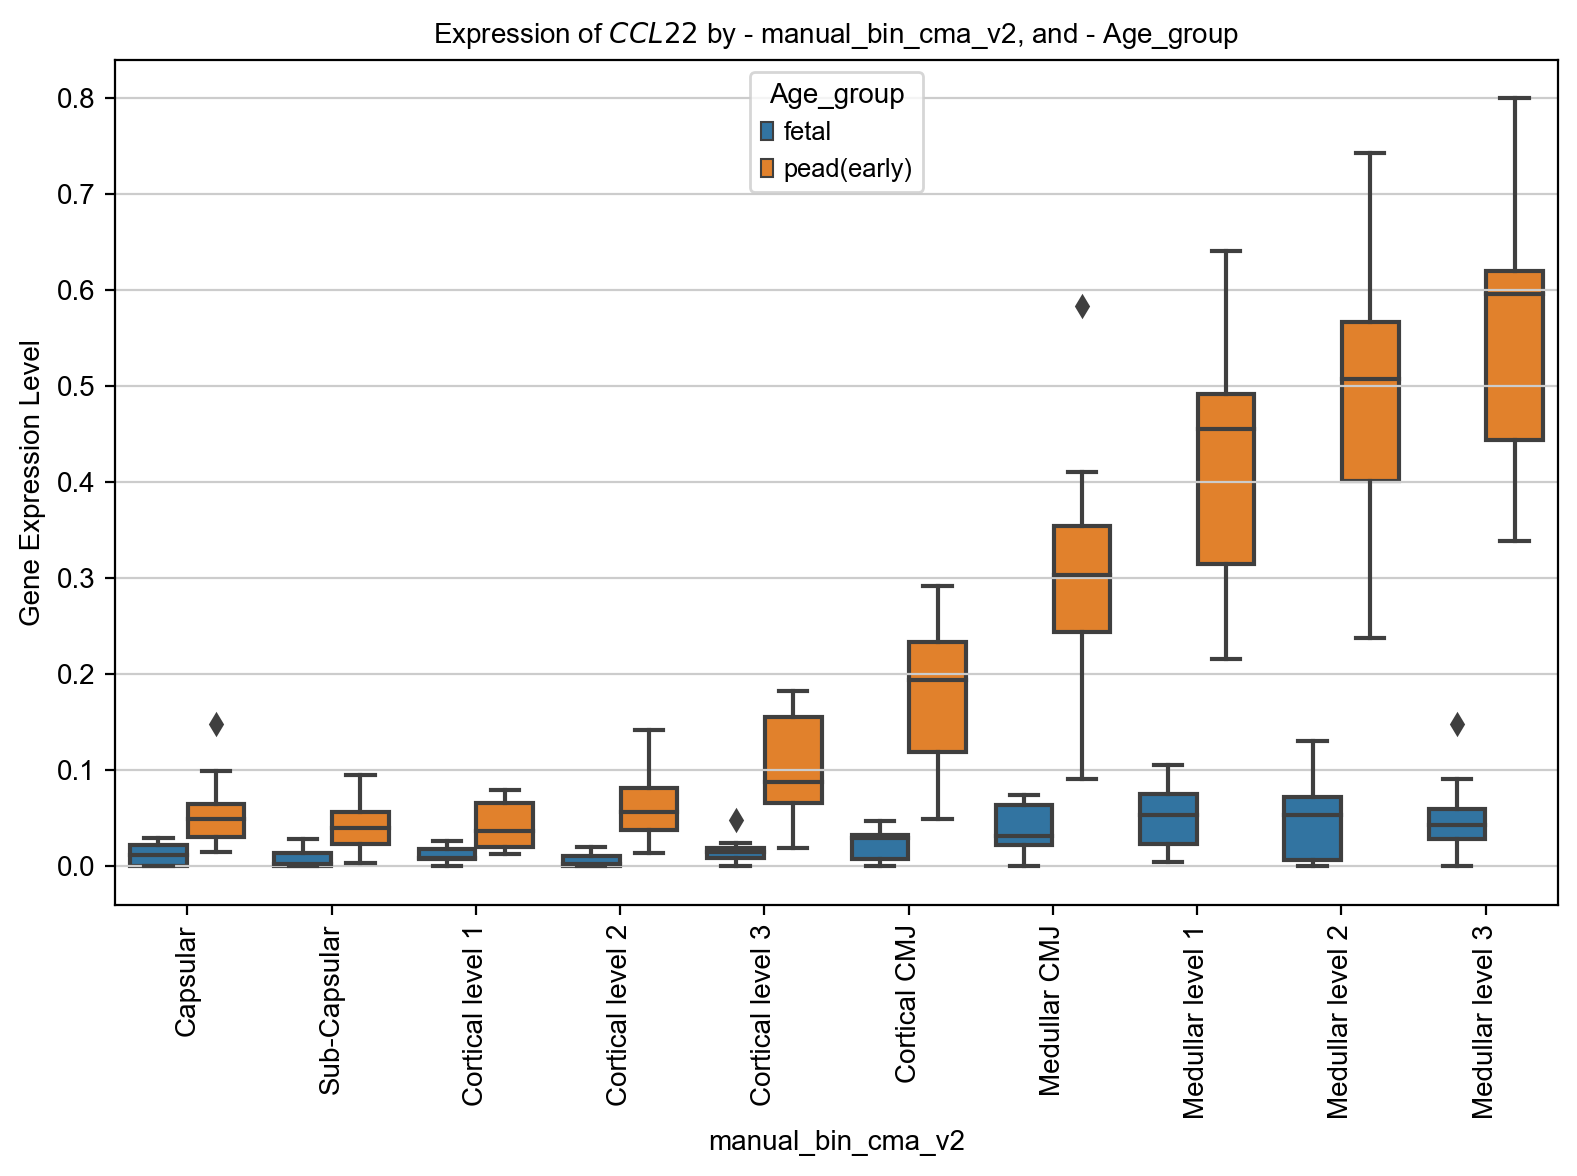

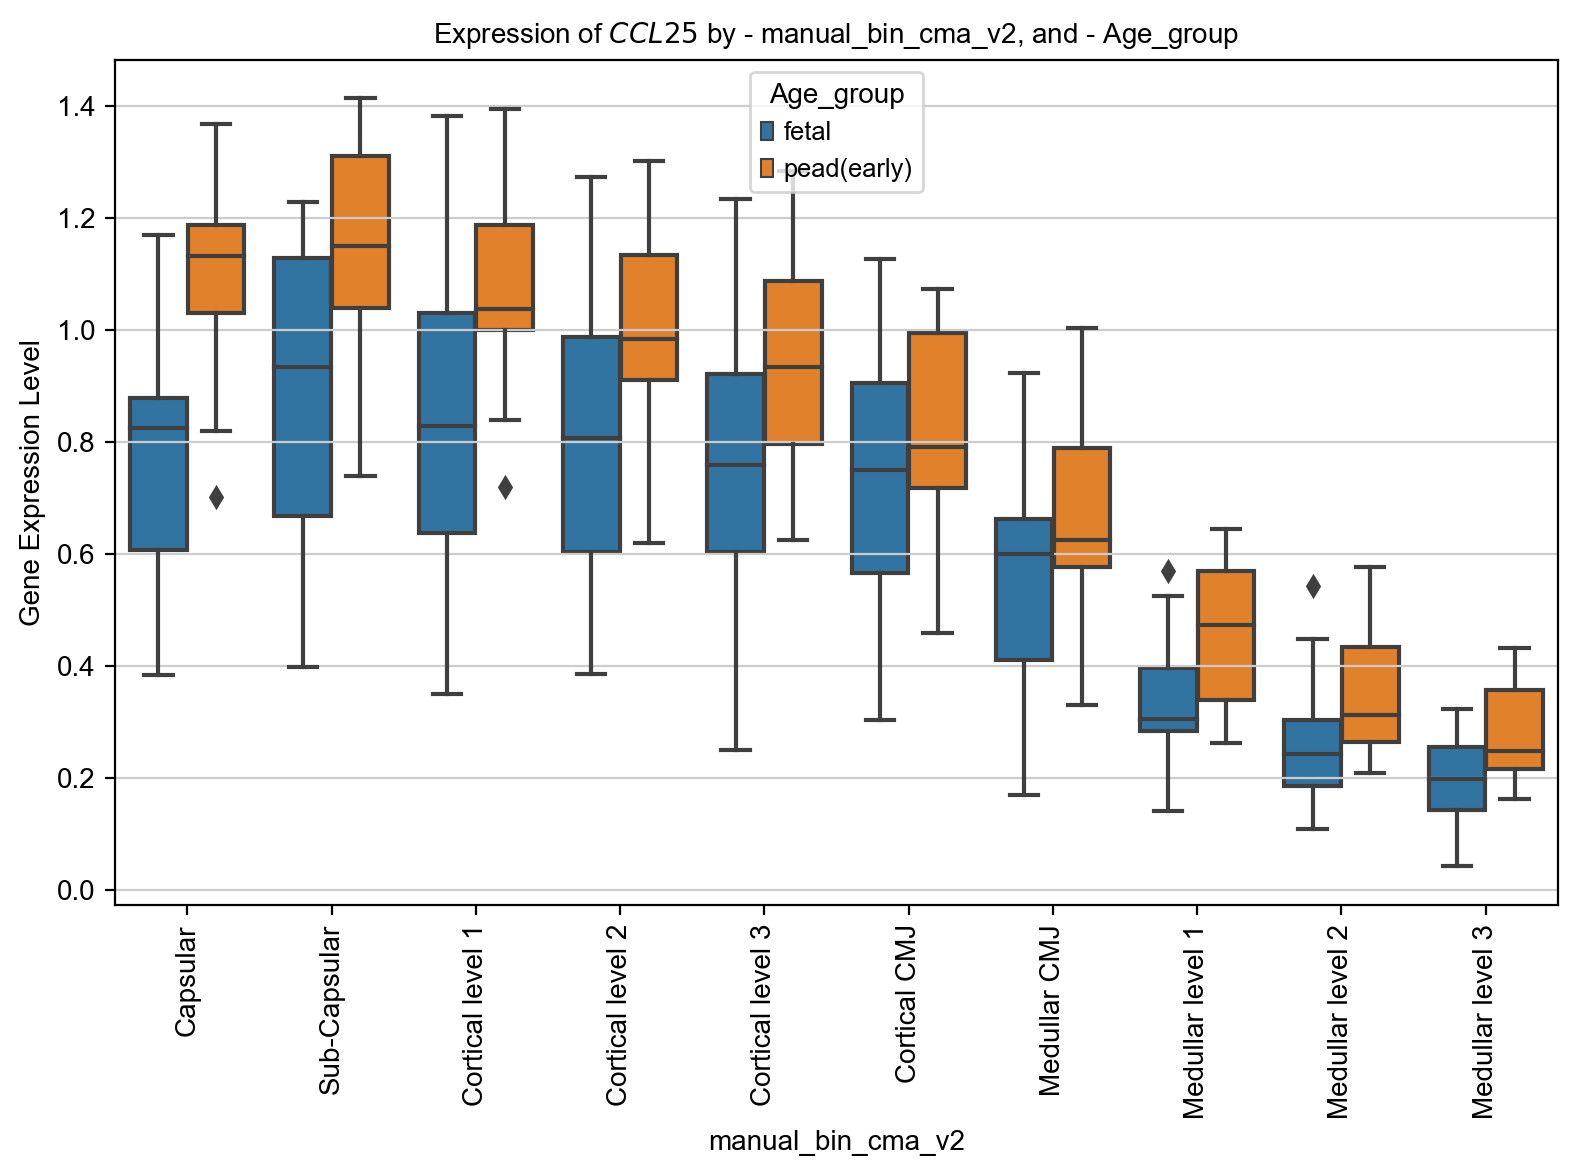

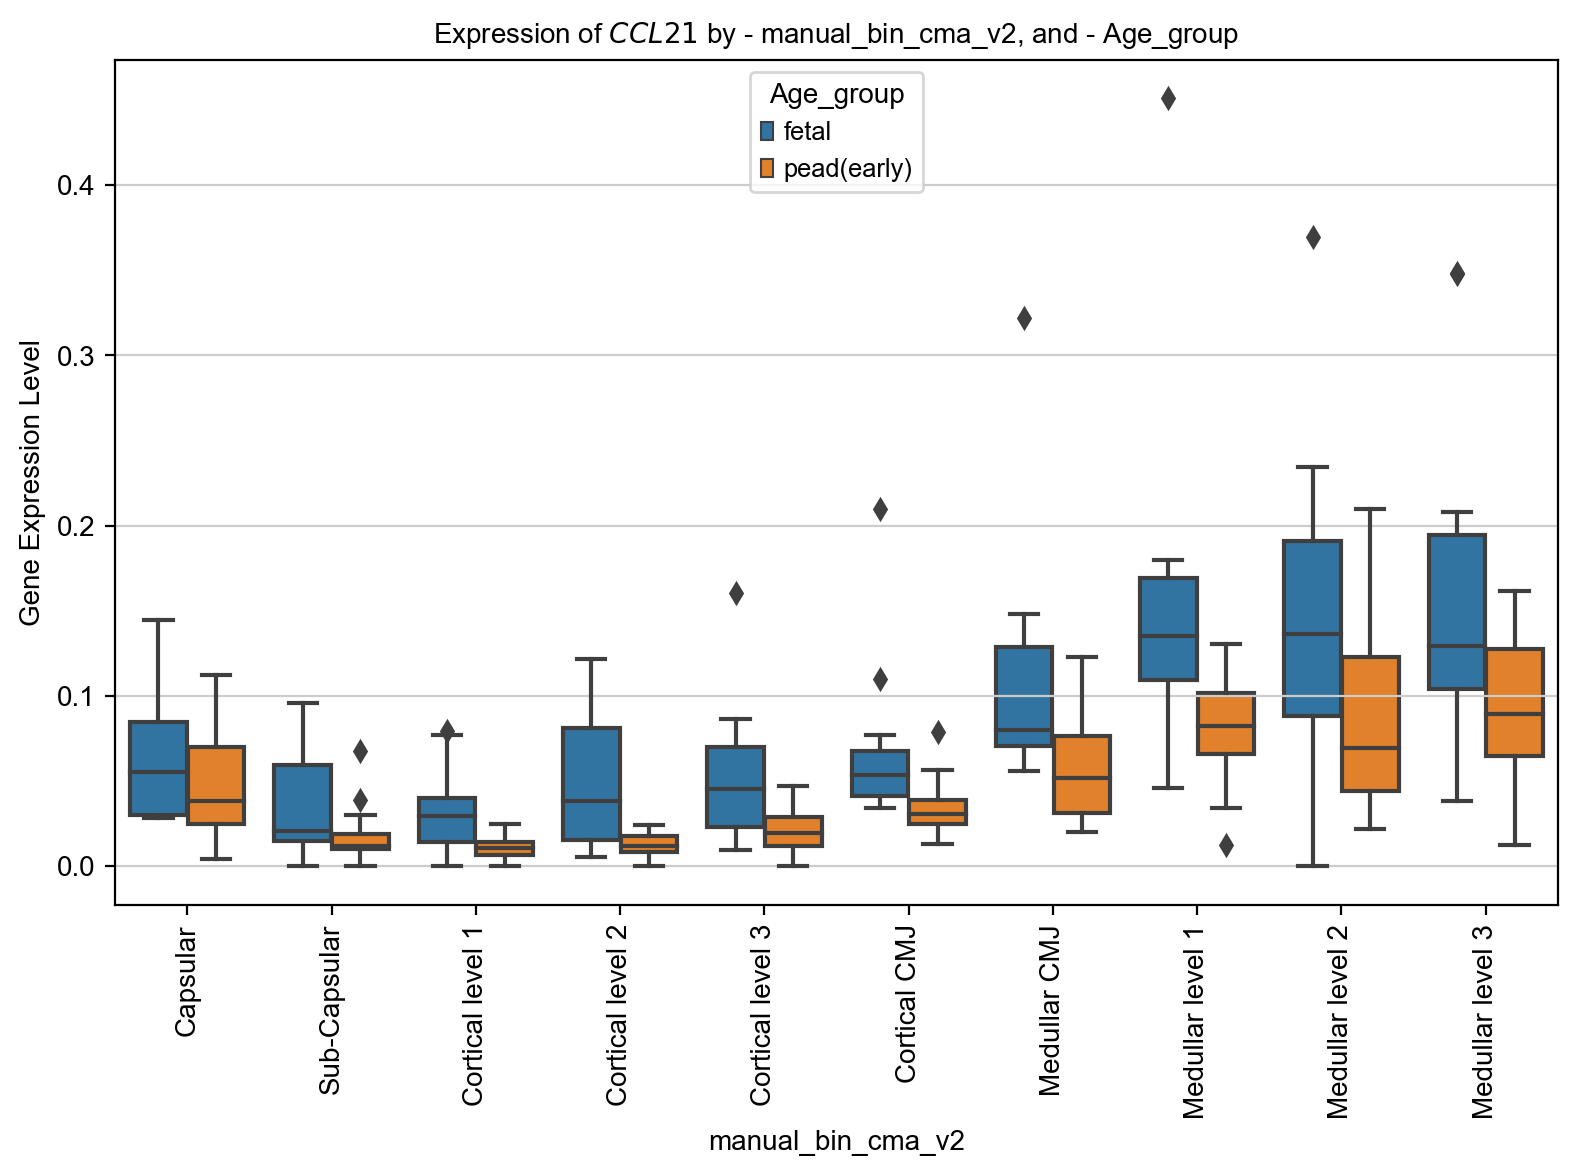

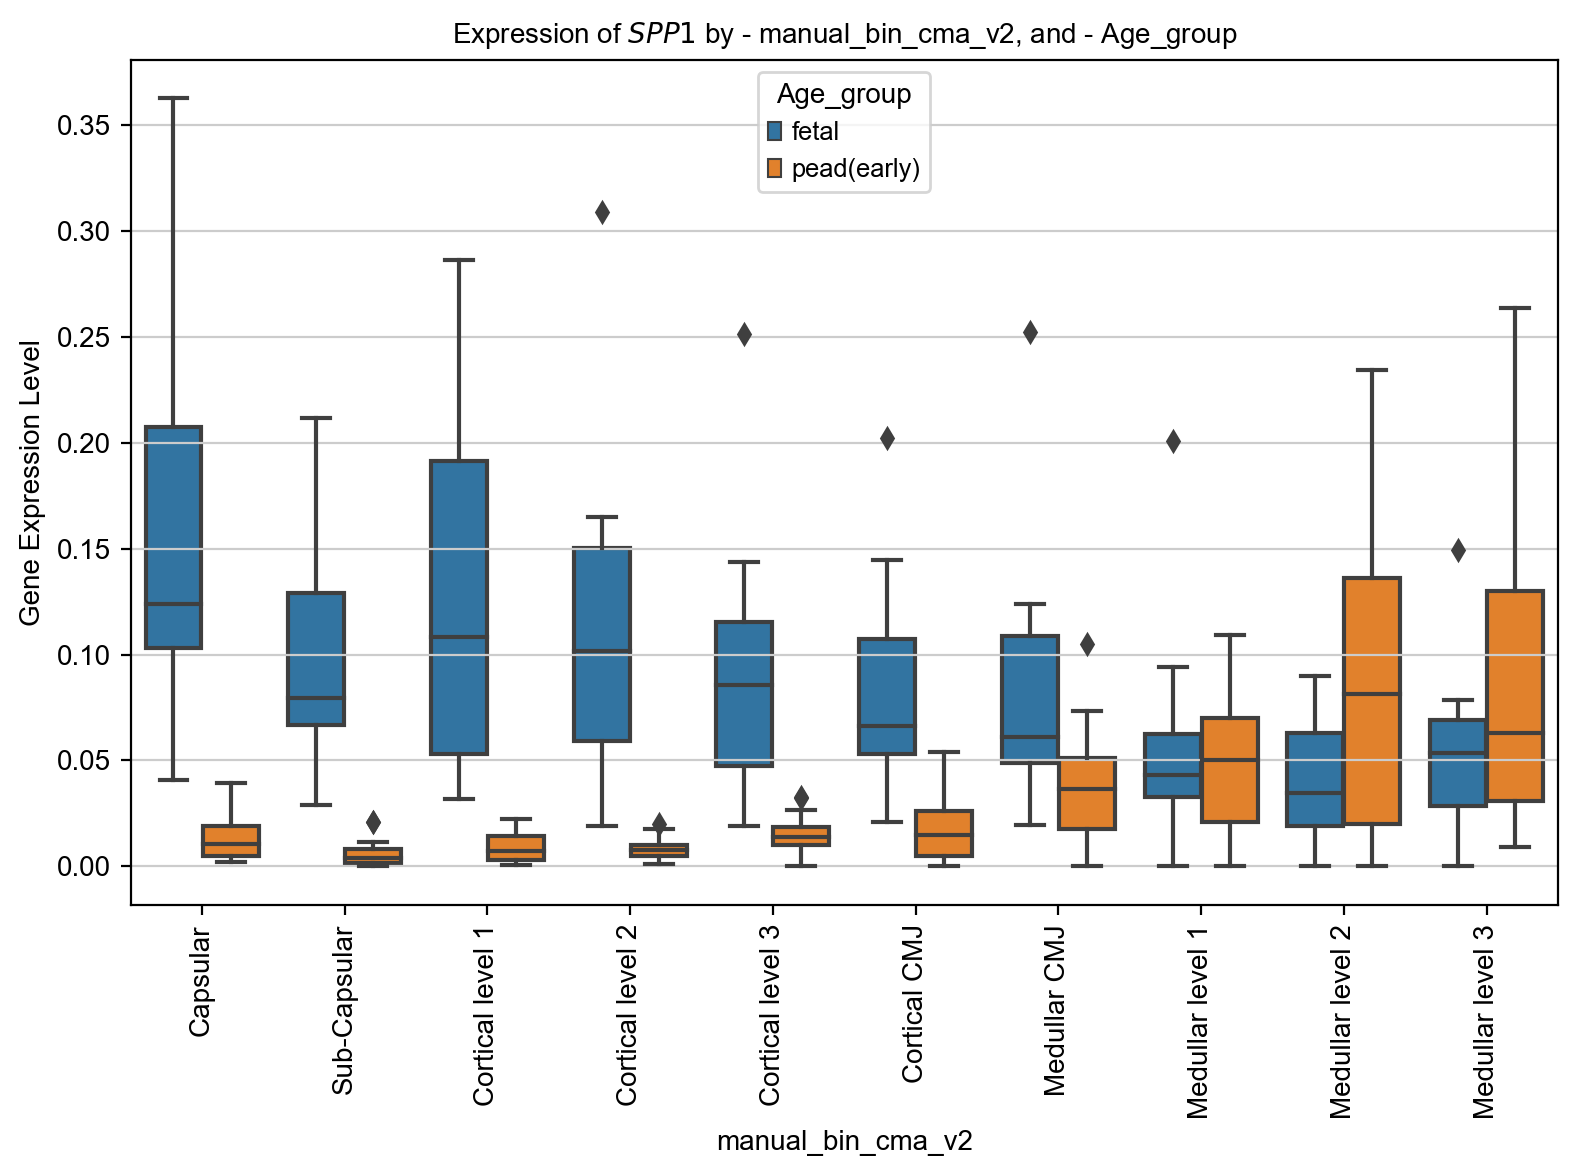

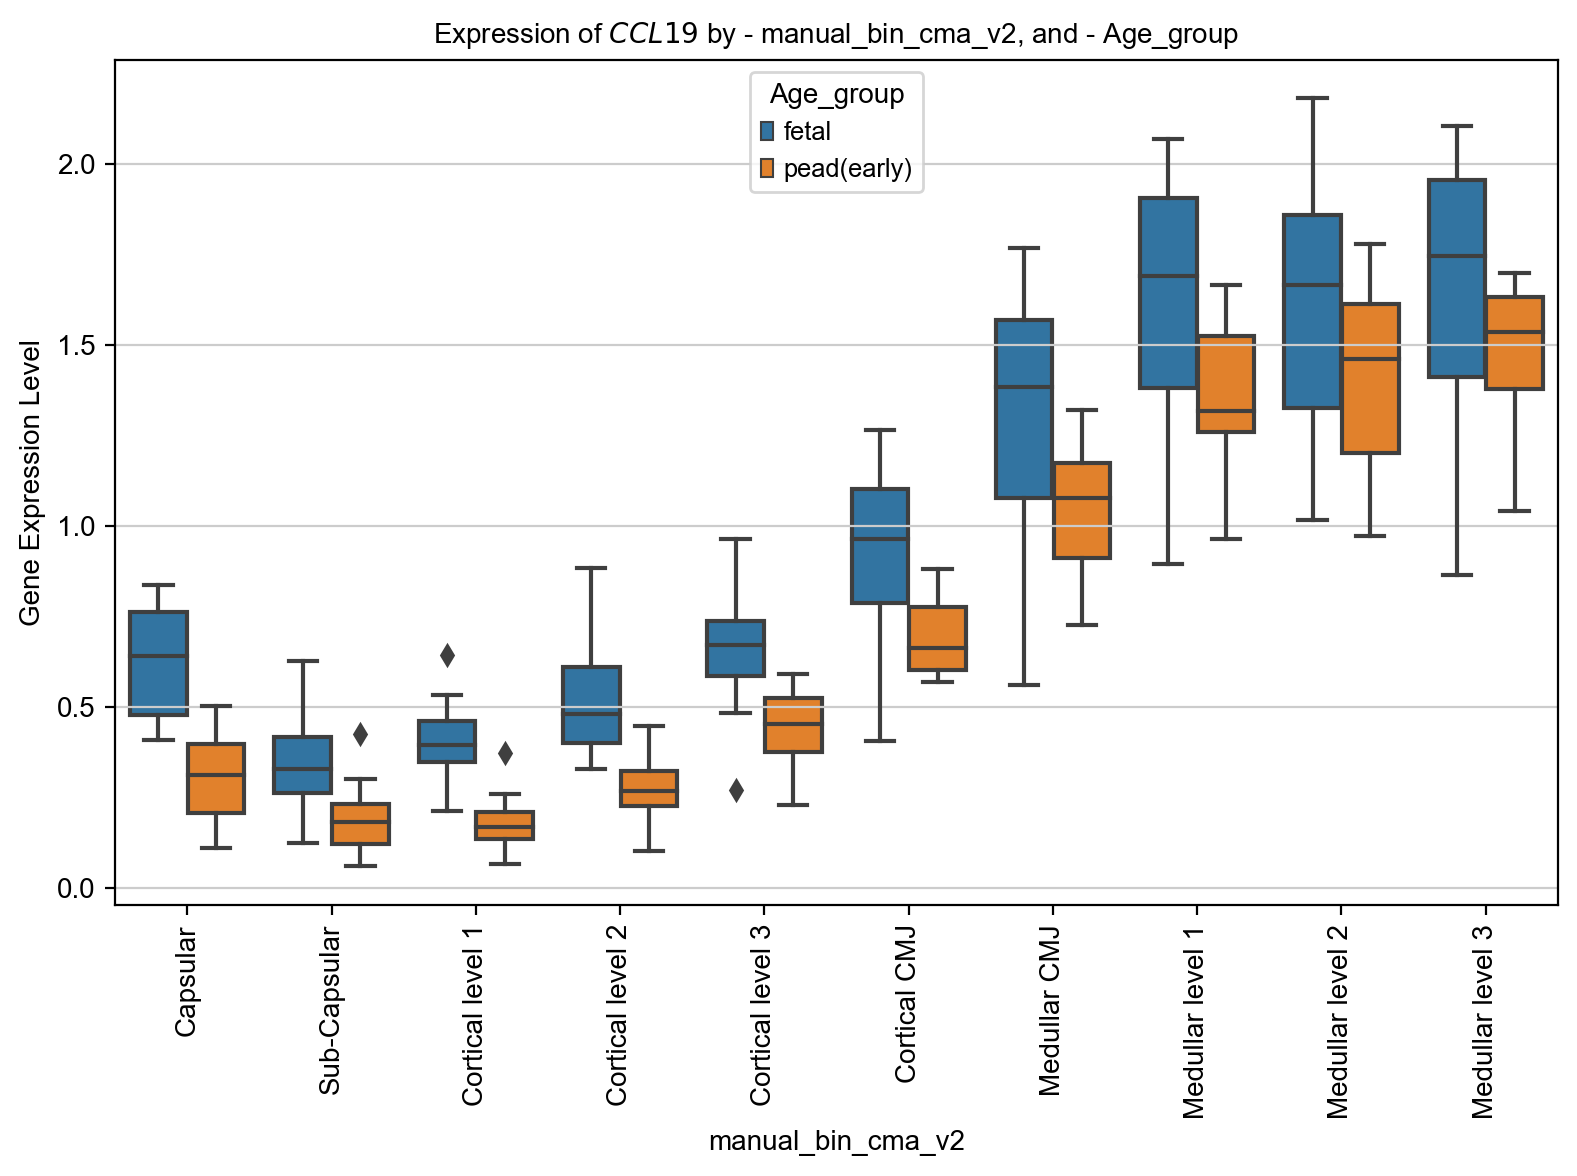

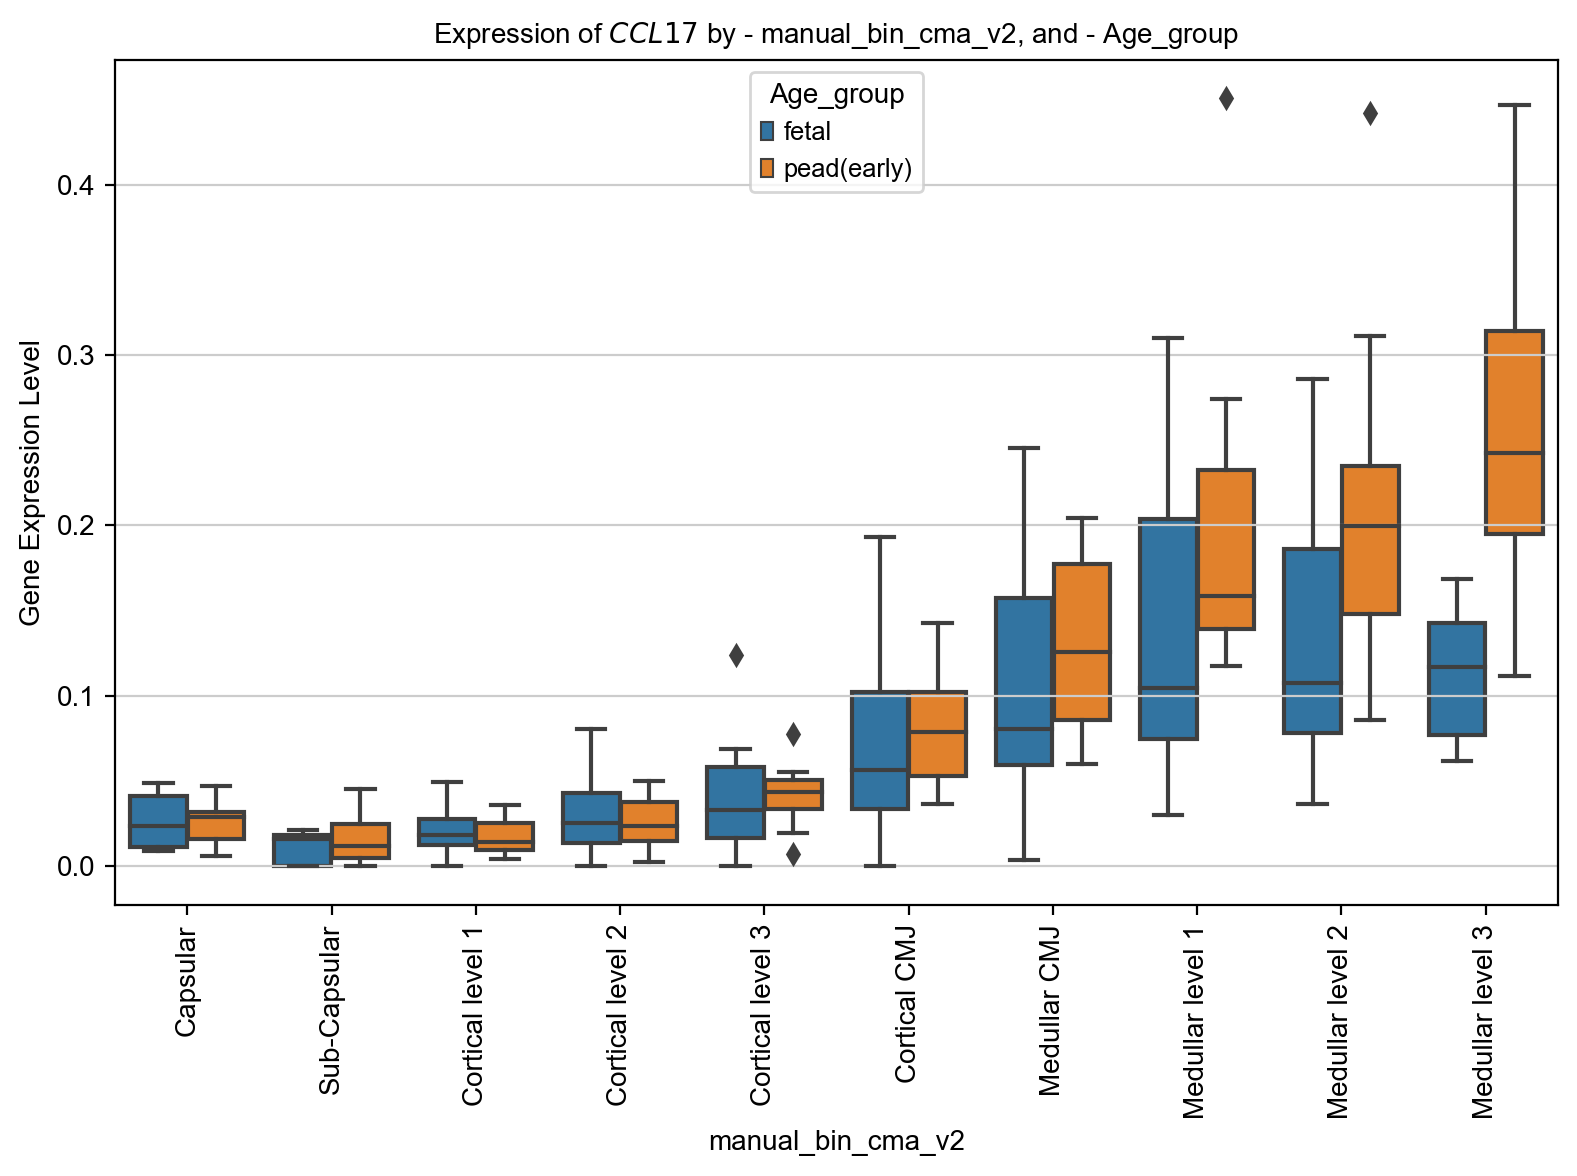

In [21]:
sc.set_figure_params(fontsize=10,dpi=100,figsize=(8, 6))
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box_groups(df_melted, genes, grouping, condition, ct_order, save_dir=None):
    for gene in genes:
        ax = plt.gca()  
        sns.boxplot(data=df_melted[df_melted['Gene'] == gene], x=grouping, y='Expression', hue=condition, order=ct_order, ax=ax)
        ax.set_title(f'Expression of $\it{{{gene}}}$ by - {grouping}, and - {condition}')
        ax.set_xlabel(grouping)
        ax.set_ylabel('Gene Expression Level')
        ax.tick_params(axis='x', rotation=90) 
        ax.legend(title=condition, loc='upper center')

        plt.tight_layout()

        if save_dir:
            filename = f"{gene}_expression_by_{grouping}_and_{condition}.pdf"
            plt.savefig(f"{save_dir}/{filename}", dpi=100)
        plt.show()
        plt.close()  # Close the figure to free memory
        


genes = ['CCL22','CCL25','CCL21','SPP1','CCL19','CCL17']
plot_box_groups(df_grouped,genes,grouping, condition, ct_order, save_dir='')

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity_per_gene_mean_centered(df, genes_of_interest, age_group1, age_group2,plot=False,mean_median='median'):
    # Calculate median expression values for each gene across tissue regions within each age group
    if mean_median == 'median':
        medmean_expressions = df.groupby([condition, grouping, 'Gene'])['Expression'].median().reset_index()
        
    if mean_median == 'mean':
        medmean_expressions = df.groupby([condition, grouping, 'Gene'])['Expression'].mean().reset_index()
    
    
    # Filter for genes of interest
    medmean_expressions = medmean_expressions[medmean_expressions['Gene'].isin(genes_of_interest)]
    
    # Mean centering: subtract the mean expression of each gene across all tissue regions within each age group
    mean_centered_expressions = medmean_expressions.copy()
    mean_centered_expressions['Mean_Centered_Expression'] = medmean_expressions.groupby([condition, 'Gene'])['Expression'].transform(lambda x: x - x.mean())
    
    # Initialize a list to store cosine similarity results
    cosine_similarities = []
    
    for gene in genes_of_interest:
        # Filter for the current gene
        gene_data = mean_centered_expressions[mean_centered_expressions['Gene'] == gene]
        
        # Pivot to get a matrix of tissue regions for each age group, using mean-centered values
        pivot_table = gene_data.pivot(index=condition, columns=grouping, values='Mean_Centered_Expression').fillna(0)
        
        # Get vectors for the specified age groups
        vector1 = pivot_table.loc[age_group1].values.reshape(1, -1)
        vector2 = pivot_table.loc[age_group2].values.reshape(1, -1)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(vector1, vector2)[0][0]
        cosine_similarities.append({'Gene': gene, 'Cosine Similarity': similarity})
    
    # Convert to DataFrame for plotting
    similarities_df = pd.DataFrame(cosine_similarities)
    if plot:
        # Plotting
        plt.figure(figsize=(len(genes_of_interest)/3,2 ))
        sns.barplot(x='Gene', y='Cosine Similarity', data=similarities_df)
        plt.title(f'Cosine Similarity between {age_group1} and {age_group2} for Each Gene (Mean Centered)')
        plt.xticks(rotation=90)
        plt.show()
    
    
    return similarities_df.set_index('Gene')

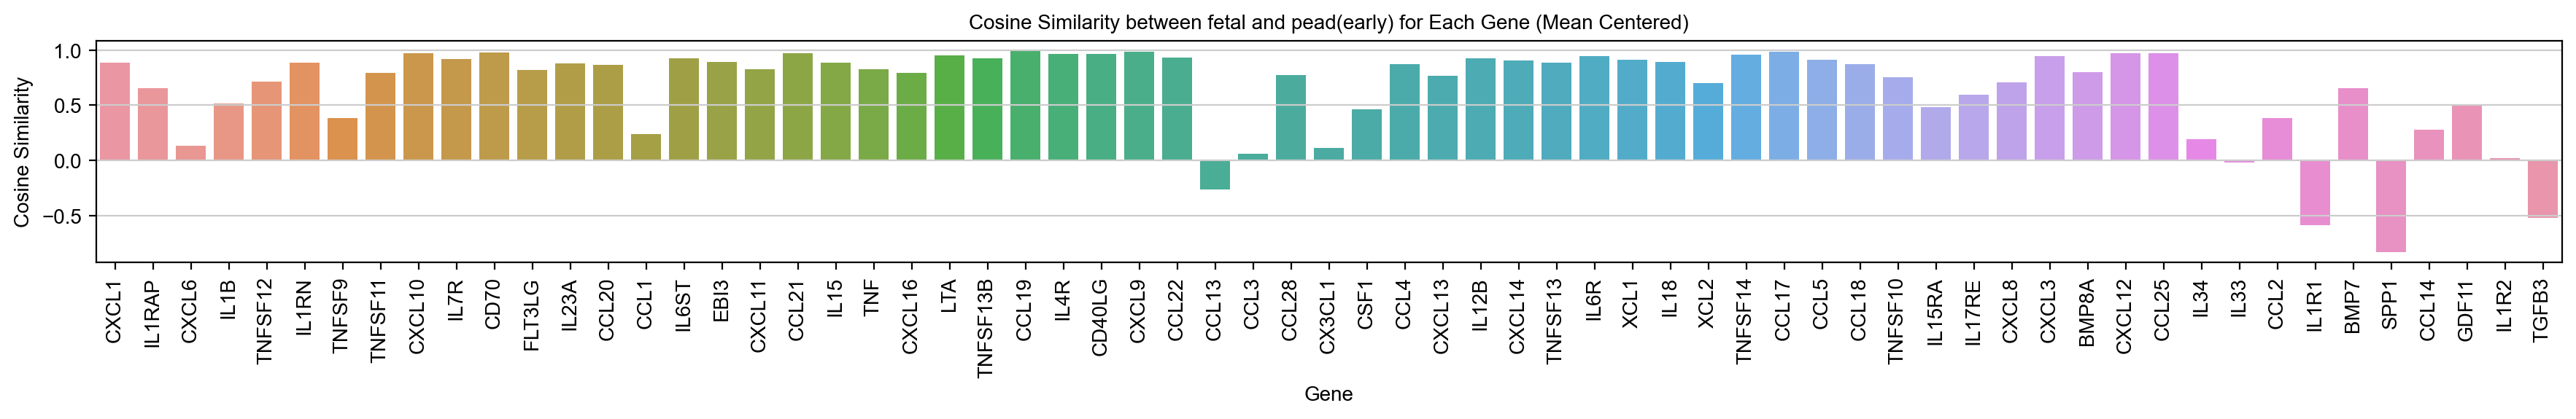

In [24]:
similarities_df = cosine_similarity_per_gene_mean_centered(df_grouped, genes_of_interest,  age_group1='fetal',  age_group2='pead(early)',mean_median='median',plot=True)

In [25]:
# Pivot the table to get each gene's expression in its own column
df_pivoted = df_grouped.pivot_table(index=[condition, grouping, batch], columns='Gene', values='Expression').reset_index()
# Ensure the 'manual_bin_cma_v2' column is ordered according to 'ct_order'
df_pivoted[grouping] = pd.Categorical(df_pivoted[grouping], categories=ct_order, ordered=True)
df_pivoted = df_pivoted.sort_values([condition,grouping, batch])
df_pivoted.reset_index(drop=True, inplace=True)
df_pivoted.to_csv('')
# df_pivoted

In [26]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
anova_results_df = pd.DataFrame(columns=['Gene', f'C({condition})_PR(>F)', f'C({grouping})_PR(>F)', 'Interaction_PR(>F)'])

for gene in genes_of_interest:
    formula = f'{gene} ~ C({condition}) * C({grouping})'
    model = ols(formula, data=df_pivoted).fit()
    
    # Perform the two-way ANOVA
    anova_results = sm.stats.anova_lm(model, typ=2)
    
    condition_p = anova_results.loc[f'C({condition})', 'PR(>F)']
    grouping_p = anova_results.loc[f'C({grouping})', 'PR(>F)']
    interaction_p = anova_results.loc[f'C({condition}):C({grouping})', 'PR(>F)']
    
    anova_results_df = anova_results_df.append({
        'Gene': gene,
        f'C({condition})_PR(>F)': condition_p,
        f'C({grouping})_PR(>F)': grouping_p,
        'Interaction_PR(>F)': interaction_p
    }, ignore_index=True)
    
anova_results_df.set_index('Gene',inplace=True)
# anova_results_df

In [27]:
# combine with cosine similarity 
comb_results = anova_results_df.join(similarities_df)
# comb_results

In [28]:
from statsmodels.stats.multitest import multipletests

# Define the columns to correct
p_value_columns = [f'C({condition})_PR(>F)', f'C({grouping})_PR(>F)', 'Interaction_PR(>F)']

# Loop through each p-value column, adjust using Bonferroni, and add the results back to the DataFrame
for col in p_value_columns:
    # Extract the p-values
    pvals = comb_results[col].values

    # Apply Bonferroni correction
    rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='bonferroni')

    # Add the corrected p-values back to the DataFrame
    comb_results[f'{col}_corrected'] = pvals_corrected

    # Optionally, add a column indicating whether the null hypothesis is rejected
    comb_results[f'{col.split("_PR(>F)")[0]}_rejected'] = rejected
    
# comb_results

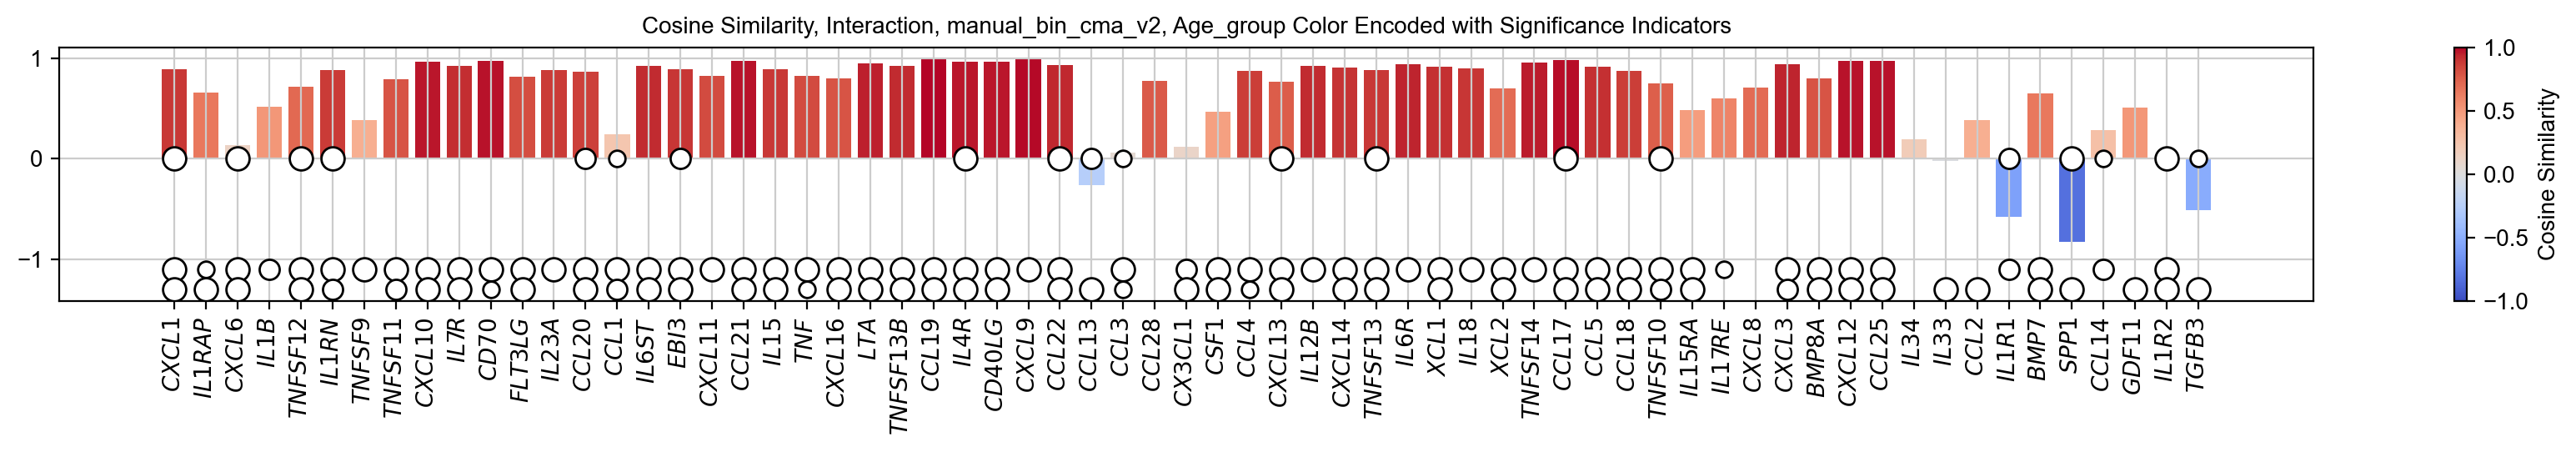

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_combined(comb_results, condition, grouping,save_path=False):
    df = comb_results.reset_index()
    
    def get_significance_level(p_value, num_categories):
        adjusted_p_value = p_value / num_categories
        if adjusted_p_value <= 0.001:
            return '***', 100  # Larger dot size for ***
        elif adjusted_p_value <= 0.01:
            return '**', 75  # Medium dot size for **
        elif adjusted_p_value <= 0.05:
            return '*', 50  # Smaller dot size for *
        else:
            return '', 0  # No dot for non-significant

    df['Int_Significance'], df['Int_Dot_Size'] = zip(*df['Interaction_PR(>F)_corrected'].apply(lambda x: get_significance_level(x, 1)))
    df['Grouping_Significance'], df['Grouping_Dot_Size'] = zip(*df[f'C({grouping})_PR(>F)_corrected'].apply(lambda x: get_significance_level(x, 1)))
    df['Cond_Significance'], df['Cond_Dot_Size'] = zip(*df[f'C({condition})_PR(>F)_corrected'].apply(lambda x: get_significance_level(x, 1)))

    norm = plt.Normalize(-1, 1)
    smap = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    df['Color'] = df['Cosine Similarity'].apply(lambda x: smap.to_rgba(x))

    plt.figure(figsize=(len(df) / 3, 2))

    for index, row in df.iterrows():
        plt.bar(row['Gene'], row['Cosine Similarity'], color=row['Color'])

    for index, row in df.iterrows():
        if row['Int_Dot_Size'] > 0:
            plt.plot(index, 0, 'wo', markersize=np.sqrt(row['Int_Dot_Size']), markeredgecolor='k')
        if row['Grouping_Dot_Size'] > 0:
            plt.plot(index, -1.1, 'wo', markersize=np.sqrt(row['Grouping_Dot_Size']), markeredgecolor='k')
        if row['Cond_Dot_Size'] > 0:
            plt.plot(index, -1.3, 'wo', markersize=np.sqrt(row['Cond_Dot_Size']), markeredgecolor='k')

    # Make gene names italic on x-axis
    ax = plt.gca()
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels([f'$\it{{{gene}}}$' for gene in df['Gene'].values], rotation=90, fontsize=10)

    plt.colorbar(smap, label='Cosine Similarity')
    plt.title(f'Cosine Similarity, Interaction, {grouping}, {condition} Color Encoded with Significance Indicators')
    if save_path:
        plt.savefig(save_path + f'Cosine Similarity_{grouping}_and_{condition}.pdf', format='pdf')
        
    plt.show()   


plot_combined(comb_results,condition=condition, grouping=grouping,save_path='')

In [29]:
comb_results.to_csv('')

# Looking at bin composition 

In [34]:
adata

AnnData object with n_obs × n_vars = 33348 × 26041
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequencer', 'DonorID', 'Don

In [35]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props

In [36]:
sc.set_figure_params(figsize=[7,3],fontsize=10,dpi=100)

def plot_cluster_proportions(cluster_props, 
                             cluster_palette='colorblind',
                             xlabel_rotation=0): 
    fig, ax = plt.subplots(dpi=300)
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cluster")
    sns.despine(fig, ax)
    # ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    ax.grid(False)
    return fig
    

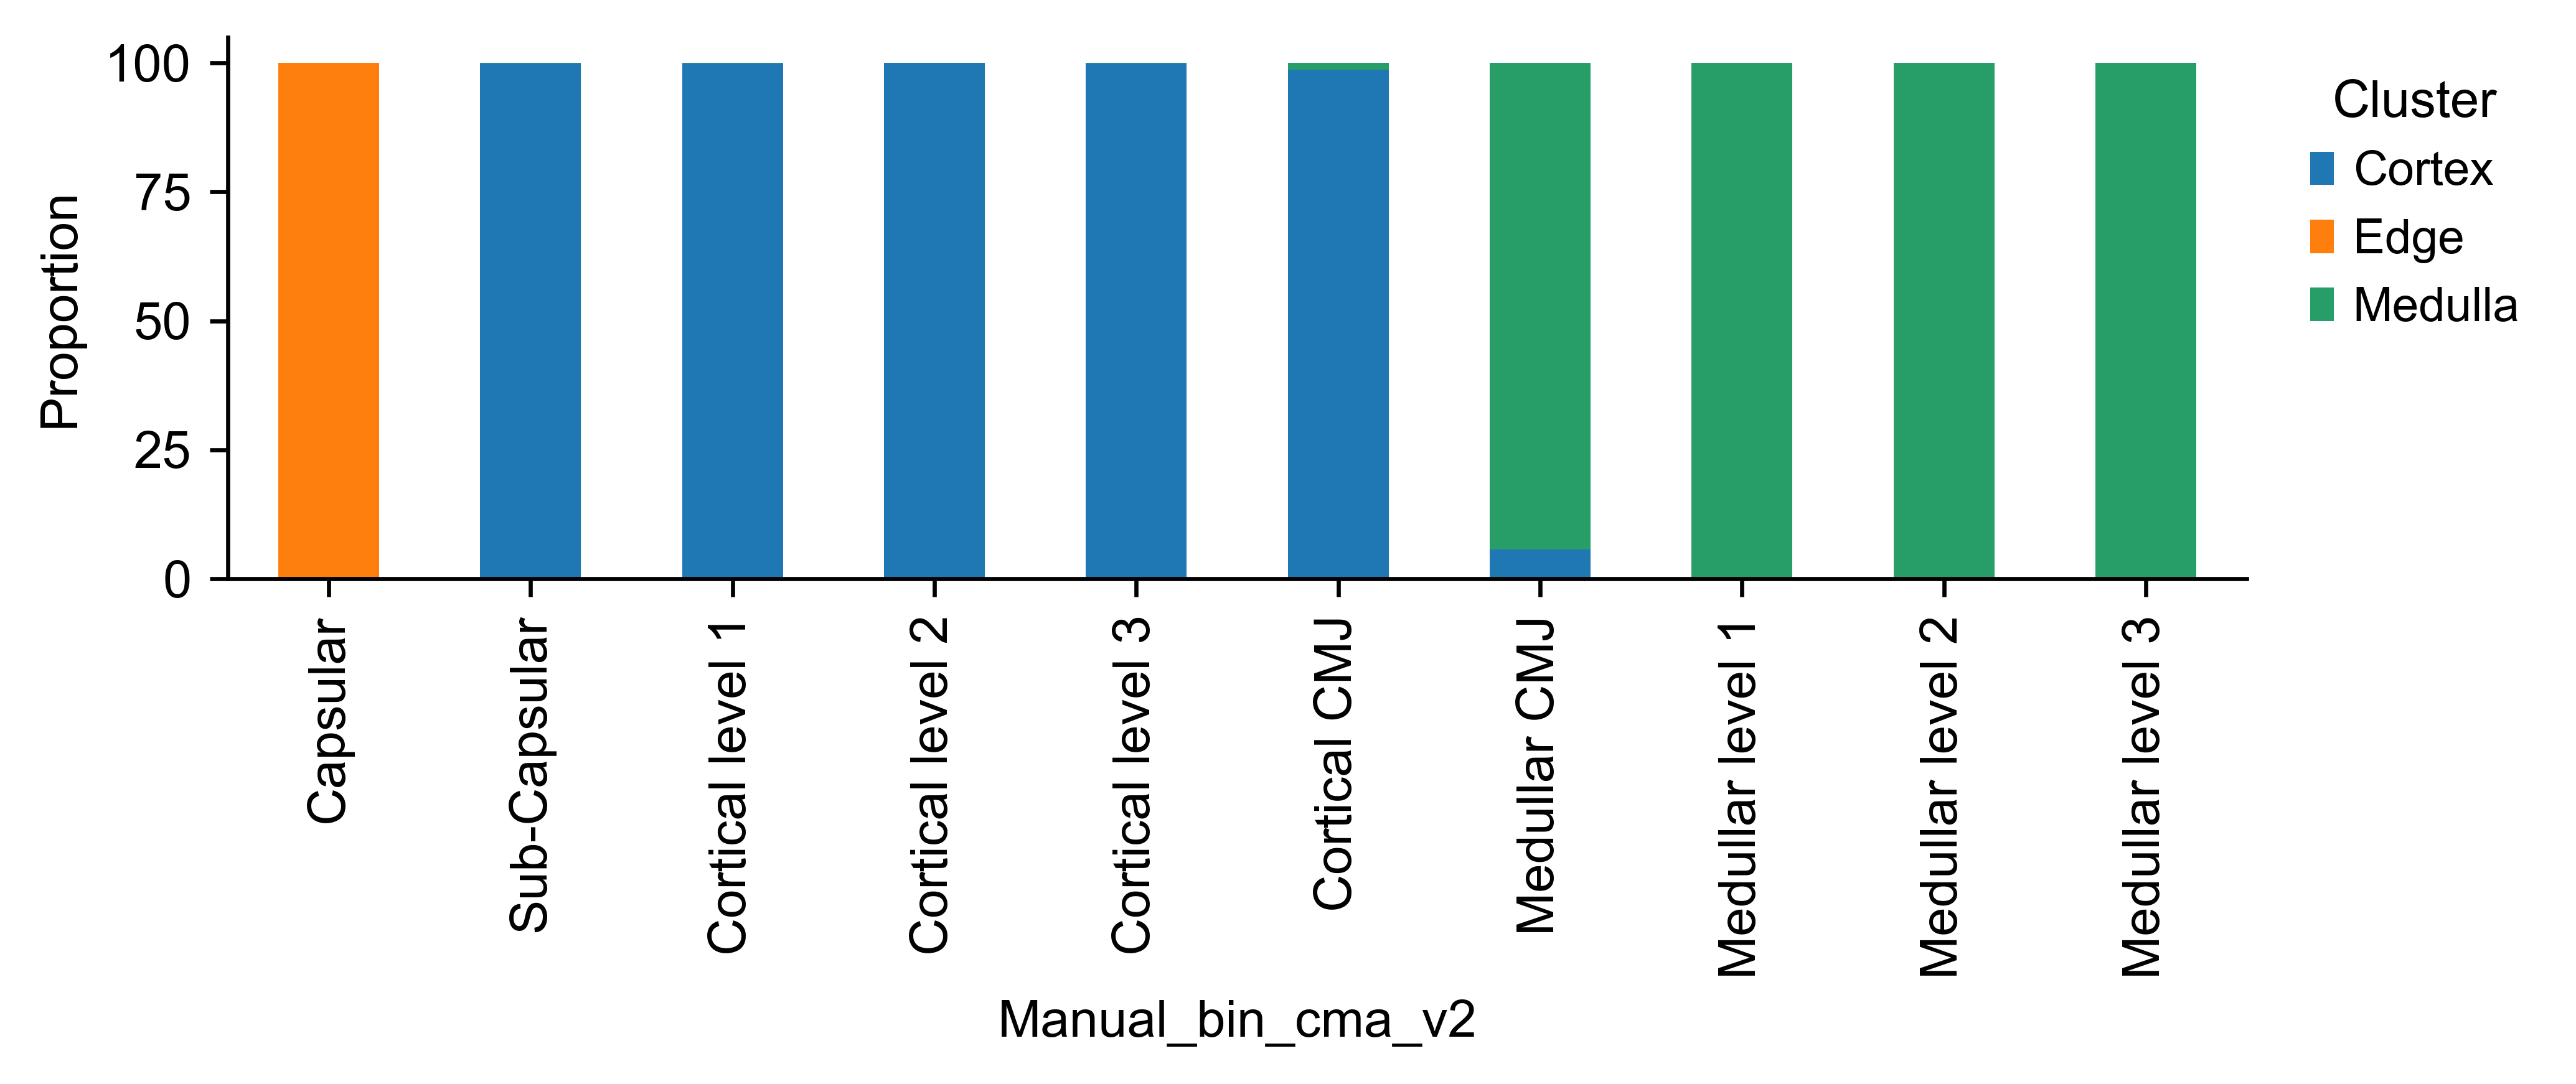

In [37]:
props = get_cluster_proportions(adata[adata.obs['Age_group']!='fetal'],
                            cluster_key="annotations_level_0",
                            sample_key="manual_bin_cma_v2",
                            drop_values=None)
fig = plot_cluster_proportions(props, 
                             cluster_palette=None,
                             xlabel_rotation=0)
fig.savefig('')

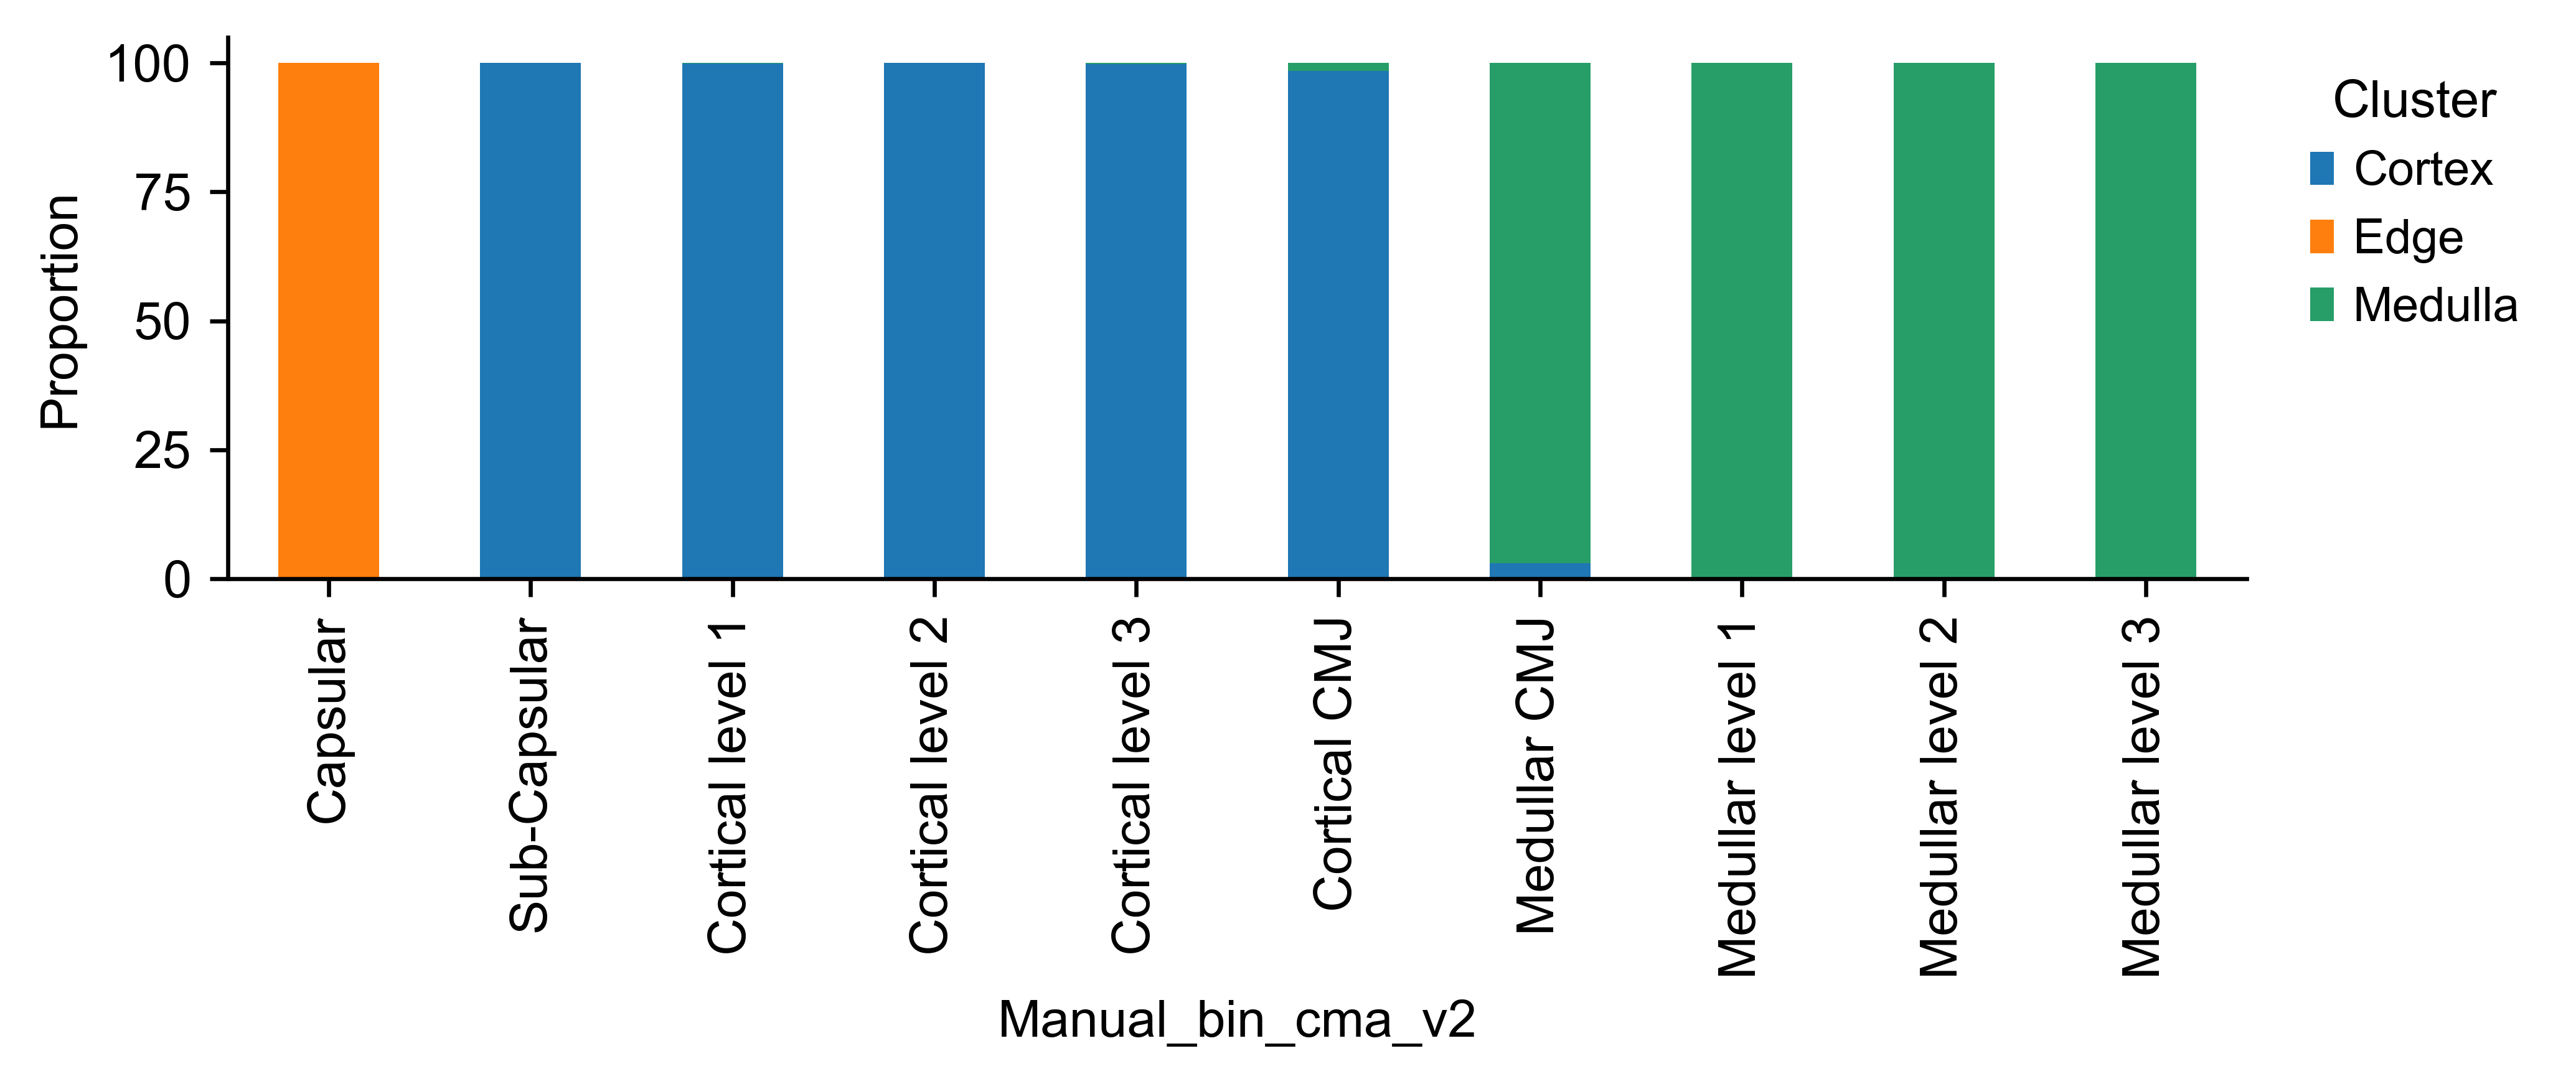

In [38]:
props = get_cluster_proportions(adata[adata.obs['Age_group']=='fetal'],
                            cluster_key="annotations_level_0",
                            sample_key="manual_bin_cma_v2",
                            drop_values=None)
fig = plot_cluster_proportions(props, 
                             cluster_palette=None,
                             xlabel_rotation=0)
fig.savefig('')

<AxesSubplot:>

Text(0, 0.5, '# of visium spots')

Text(0.5, 1.0, 'spots per bin - Paediatric')

View of AnnData object with n_obs × n_vars = 23258 × 26041
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequencer', 'DonorI

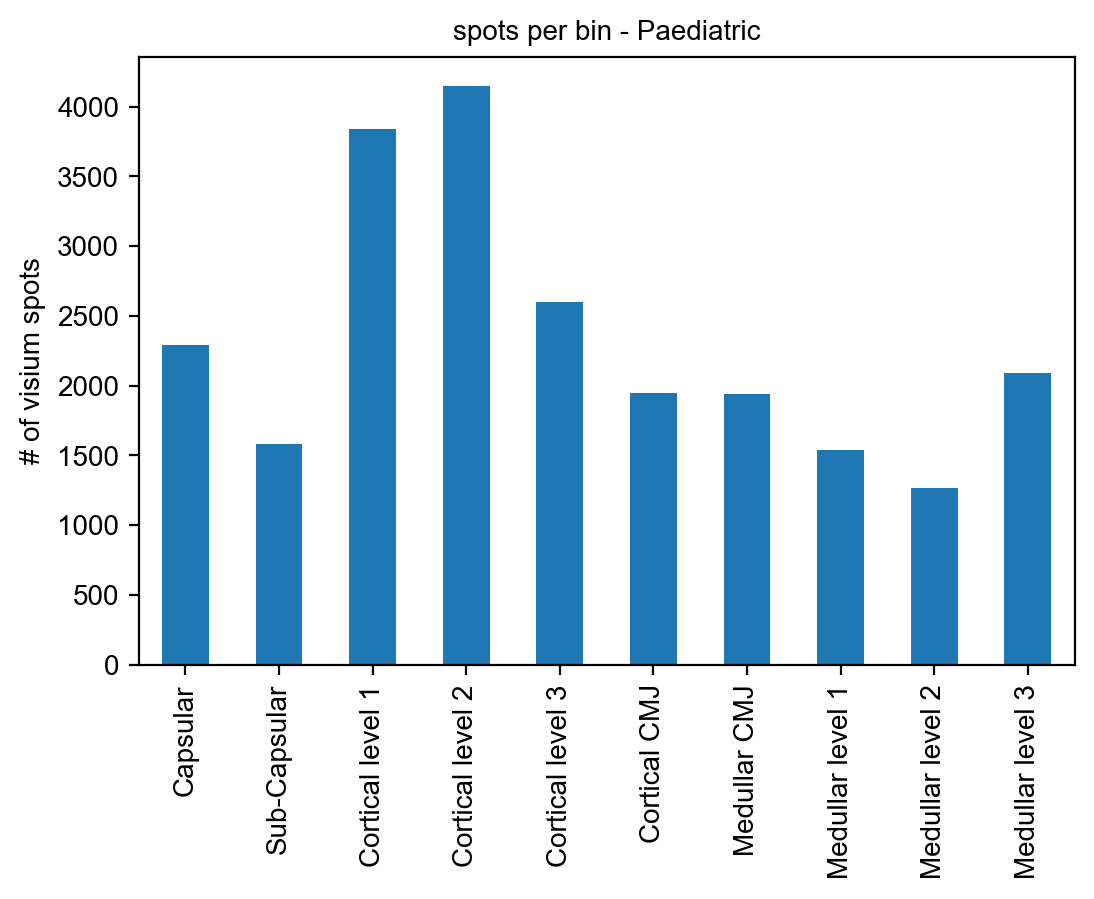

In [32]:
sc.set_figure_params(figsize=[6,4],fontsize=10,dpi=100)
fig, ax = plt.subplots(dpi=100)
adata[adata.obs['Age_group']!='fetal'].obs["manual_bin_cma_v2"].value_counts(sort=False).plot.bar(grid=False)         
ax.set_ylabel("# of visium spots")
ax.set_title("spots per bin - Paediatric")
adata[adata.obs['Age_group']!='fetal']

<AxesSubplot:>

Text(0, 0.5, '# of visium spots')

Text(0.5, 1.0, 'spots per bin - Fetal')

AnnData object with n_obs × n_vars = 33348 × 26041
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequencer', 'DonorID', 'Don

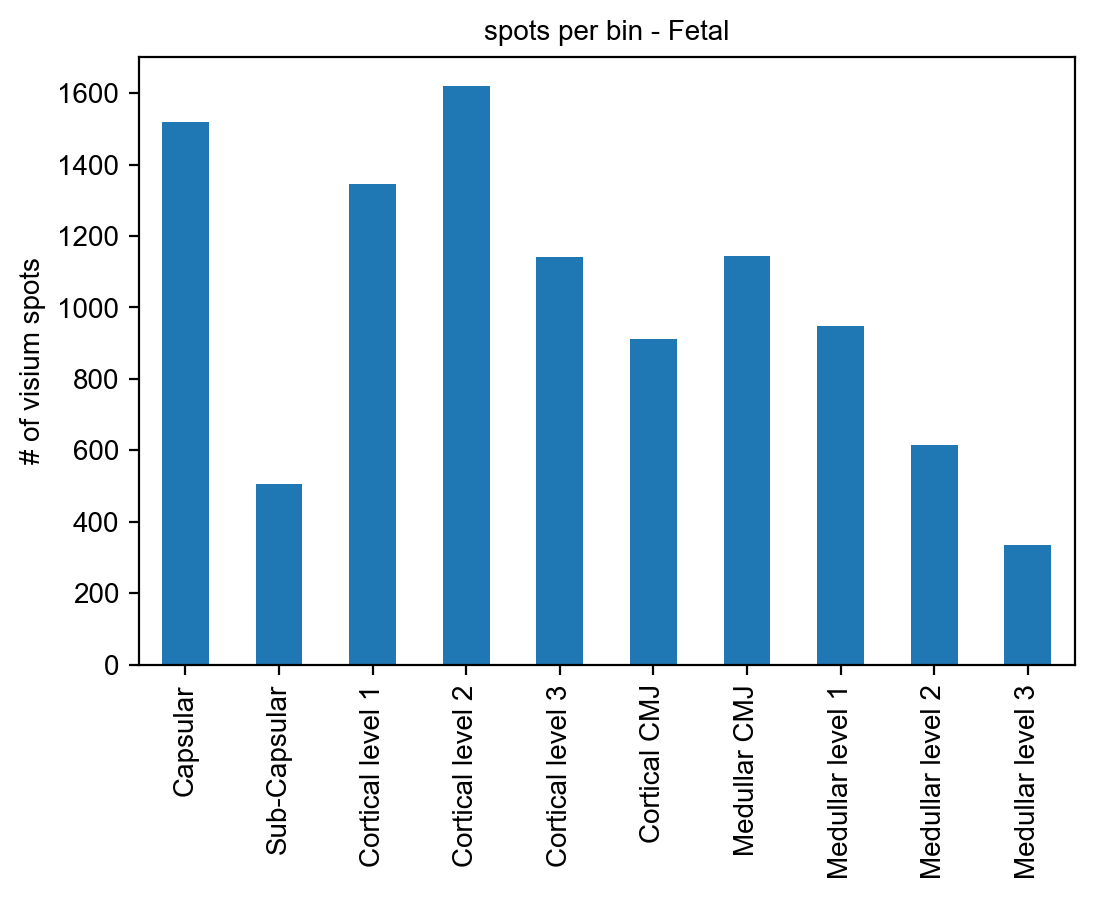

In [35]:
fig, ax = plt.subplots(dpi=100)
adata[adata.obs['Age_group']=='fetal'].obs["manual_bin_cma_v2"].value_counts(sort=False).plot.bar(grid=False)         
ax.set_ylabel("# of visium spots")
ax.set_title("spots per bin - Fetal")
adata            

<AxesSubplot:>

Text(0, 0.5, '# of visium spots')

Text(0.5, 1.0, 'spots per bin - all ages')

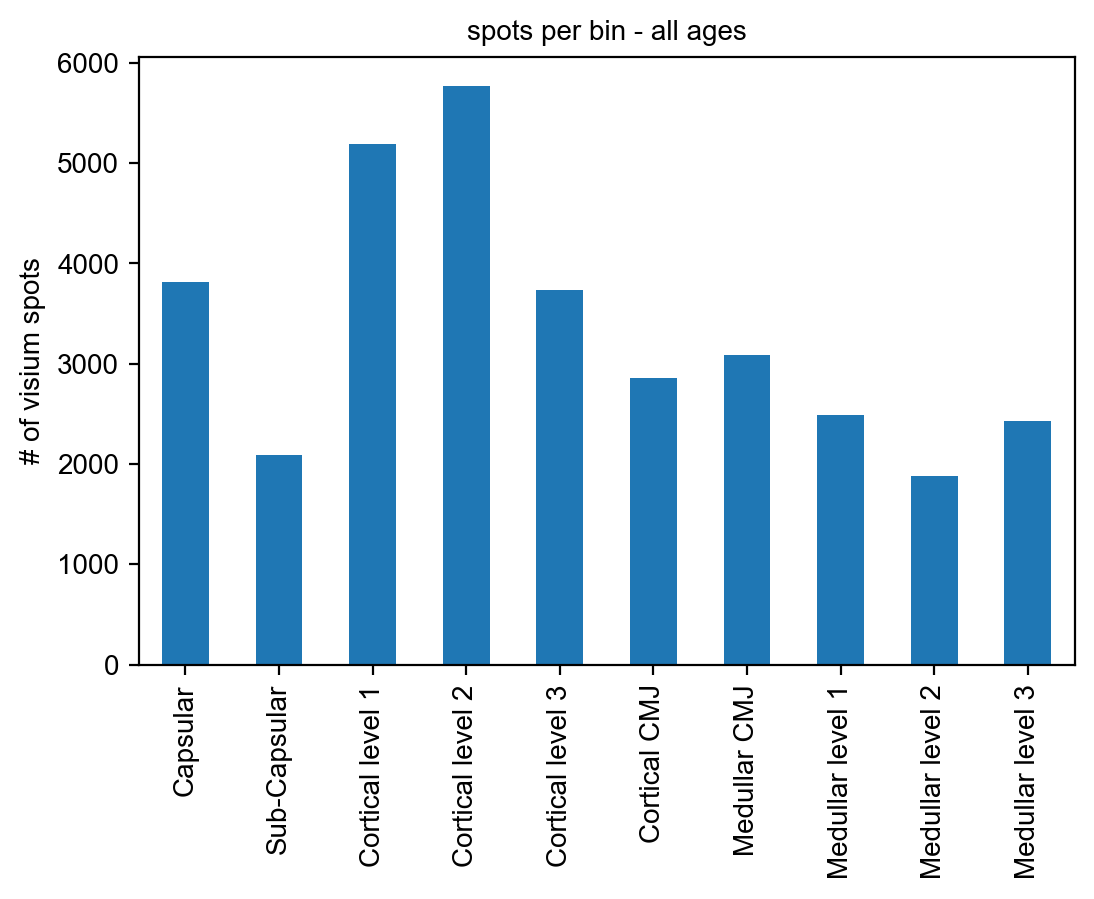

In [41]:
fig, ax = plt.subplots(dpi=100)
adata.obs["manual_bin_cma_v2"].value_counts(sort=False).plot.bar(grid=False)         
ax.set_ylabel("# of visium spots")
ax.set_title("spots per bin - all ages")
                